<a href="https://colab.research.google.com/github/robd123/IndepResearch/blob/master/Notebooks/FN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
model_name = "t5-small"
token_len = 512
model_prefix = f"{model_name}-{token_len}"

In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.2 MB 6.7 MB/s 


In [ ]:
pip install pytorch-lightning

     |████████████████████████████████| 527 kB 9.7 MB/s 
     |████████████████████████████████| 952 kB 46.9 MB/s 
     |████████████████████████████████| 133 kB 73.6 MB/s 
     |████████████████████████████████| 829 kB 72.7 MB/s 
     |████████████████████████████████| 596 kB 65.3 MB/s 
     |████████████████████████████████| 397 kB 73.6 MB/s 
     |████████████████████████████████| 1.1 MB 52.3 MB/s 
     |████████████████████████████████| 144 kB 55.3 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 49.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=d24cc2e33a9a5164254fa4d900a4e6702434816eb20957254698163c21a78182
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

In [ ]:
pip install nlp

     |████████████████████████████████| 1.7 MB 8.2 MB/s 
     |████████████████████████████████| 243 kB 71.4 MB/s 


In [ ]:
pip install transformers

     |████████████████████████████████| 3.5 MB 9.4 MB/s 
     |████████████████████████████████| 895 kB 45.3 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 6.8 MB 59.8 MB/s 


In [ ]:
pip install wandb

     |████████████████████████████████| 1.7 MB 8.4 MB/s 
     |████████████████████████████████| 180 kB 65.7 MB/s 
     |████████████████████████████████| 143 kB 70.9 MB/s 
     |████████████████████████████████| 63 kB 402 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4e04df20afc1783b8cf843ea9b7b46fe1bedd7d8a83b681db67c861d8bc00e39
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
from pytorch_lightning.loggers.wandb import WandbLogger
import os
from pathlib import Path
from string import punctuation

os.environ["WANDB_API_KEY"] = '33461c97826e5a650bb71bec8b3e694e7c6ee9f6'
wandb_logger = WandbLogger(project='fakenews-t5small')

In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import string
import pandas as pd
# pd.set_option('display.max_colwidth', -1)
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
import random
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import auth
auth.authenticate_user()

!gcloud config set project eternal-bruin-340122

!gsutil cp gs://robd_indep_research/fake_full.csv /tmp/dataset.csv

Updated property [core/project].
Copying gs://robd_indep_research/fake_full.csv...
\ [1 files][101.2 MiB/101.2 MiB]                                                
Operation completed over 1 objects/101.2 MiB.                                    


In [ ]:
data = pd.read_csv('/tmp/dataset.csv')

In [ ]:
data.head()

,text,label
0,Why Did Attorney General Loretta Lynch Plead T...,bias
1,Red State : \nFox News Sunday reported this mo...,bias
2,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,bias
3,Print Hillary goes absolutely berserk! She exp...,bias
4,BREAKING! NYPD Ready To Make Arrests In Weiner...,bias


In [ ]:
data.shape

(20755, 2)

In [ ]:
import numpy as np
import pandas as pd


class NewsData(Dataset):
    def __init__(self, df, tokenizer, type_path, num_samples, input_length=4096, output_length=4096, print_text=False):         
        ## Shuffle data set
        df = df.sample(frac=1, random_state=1)
        self.dataset = []
        val_size = int(0.2 * df.shape[0])

        inps = df["text"].values.tolist()
        lbls = df["label"].values.tolist()

        for i, inp in enumerate(inps):
            inp = inp.replace(":", "")
            inp = "classify: " + inp
            lbl = str(lbls[i])
            self.dataset.append({"inp": inp, "lbl": lbl})
        
        if type_path == "train":
            self.dataset = self.dataset[:len(self.dataset) - val_size - val_size]
        elif type_path == "validation":
            self.dataset = self.dataset[len(self.dataset) - val_size - val_size: len(self.dataset) - val_size]
        elif type_path == "test":
            self.dataset = self.dataset[len(self.dataset) - val_size:]

        if num_samples:
            self.dataset = self.dataset[:num_samples]
        
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
        
  
    def __len__(self):
        return len(self.dataset)

    def convert_to_features(self, example_batch):
        
        input_ = example_batch['inp']
        target_ = example_batch['lbl']
    
        
        input_ = input_.strip()

        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")

        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        if self.print_text:
            print("Lens are: ", source['input_ids'][0].shape, targets['input_ids'][0].shape)
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        # return {"source_ids": source_ids, "target_ids": target_ids}

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}



def get_dataset(tokenizer, type_path, num_samples, args, df=data):
      return NewsData(df = df, tokenizer=tokenizer, type_path=type_path, num_samples=num_samples, input_length=args.max_input_length, 
                        output_length=args.max_output_length)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
dataset = NewsData(data, tokenizer, 'validation', None, token_len, 512, True)
len(dataset)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

4151

In [ ]:
data_sc = dataset[3]
print()
print("Shape of Tokenized Text: ", data_sc['source_ids'].shape)
print()
print("Sanity check - Decode Text: ", tokenizer.decode(data_sc['source_ids']))
print("====================================")
print("Sanity check - Decode Classification: ", tokenizer.decode(data_sc['target_ids']))

Lens are:  torch.Size([512]) torch.Size([512])

Shape of Tokenized Text:  torch.Size([512])

Sanity check - Decode Text:  classify: Warren E. Buffett is not running for president. But on Monday, Mr. Buffett, the billionaire investor, volunteered more detailed information about his income taxes than Donald J. Trump, the Republican nominee, ever has. Mr. Buffett released the information after essentially being called out by Mr. Trump during Sunday night’s presidential debate. Acknowledging for the first time that he had avoided paying federal income taxes for years by claiming nearly a billion dollars in losses in 1995, Mr. Trump then tried to shift attention to his Democratic opponent, Hillary Clinton, accusing some of her wealthy supporters of exploiting tax laws to their own advantage. “Many of her friends took bigger deductions,” Mr. Trump said. “Warren Buffett took a massive deduction. ” Actually, he did not. “I have paid federal income tax every year since 1944,” Mr. Buffett wrote 

In [ ]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def white_space_fix(text):
        return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix((remove_punc(lower(s))))

In [ ]:
def exact_match_score(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

In [ ]:
def calculate_scores(predictions, ground_truths):
    em_score = 0
    subset_match_score = 0
    
    for i in range(len(predictions)):
        ground_truth = ground_truths[i]
        prediction = predictions[i]
        em_score +=  exact_match_score(prediction, ground_truth)
    
    em_score /= len(predictions)
    return em_score*100

In [ ]:
class T5FakeNewsDetector(pl.LightningModule):
    def __init__(self, hparams):
        super(T5FakeNewsDetector, self).__init__()
        self.save_hyperparameters(hparams)        
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path, return_dict=True)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path, max_length=hparams.max_input_length)
        self.output_dir = Path(self.hparams.output_dir)
        self.step_count = 0
        
        if self.hparams.freeze_embeds:
            self.freeze_embeds()
        if self.hparams.freeze_encoder:
            self.freeze_params(self.model.get_encoder())
            assert_all_frozen(self.model.get_encoder())
            
            
        n_observations_per_split = {
            "train": self.hparams.n_train,
            "validation": self.hparams.n_val,
            "test": self.hparams.n_test,
        }
        self.n_obs = {k: v if v >= 0 else None for k, v in n_observations_per_split.items()}
        self.em_score_list = []
        
    def freeze_params(self, model):
        for par in model.parameters():
            par.requires_grad = False
            
    def freeze_embeds(self):
        try:
            self.freeze_params(self.model.model.shared)
            for d in [self.model.model.encoder, self.model.model.decoder]:
                freeze_params(d.embed_positions)
                freeze_params(d.embed_tokens)
        except AttributeError:
            self.freeze_params(self.model.shared)
            for d in [self.model.encoder, self.model.decoder]:
                self.freeze_params(d.embed_tokens)

    def lmap(self, f, x):
        return list(map(f, x))

    def is_logger(self):
        return self.trainer.global_rank <= 0
    
    def parse_score(self, result):
        return {k: round(v.mid.fmeasure * 100, 4) for k, v in result.items()}
        
    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):
        return self.model(
                input_ids,
                attention_mask=attention_mask,
                decoder_input_ids=decoder_input_ids,
                decoder_attention_mask=decoder_attention_mask,
                labels=lm_labels
            )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    def ids_to_clean_text(self, generated_ids):
        gen_text = self.tokenizer.batch_decode(
            generated_ids,
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=True
        )
        return self.lmap(str.strip, gen_text)
    
    def _generative_step(self, batch) :
        
        t0 = time.time()
        # print(batch)
        inp_ids = batch["source_ids"]
        
        generated_ids = self.model.generate(
            batch["source_ids"],
            attention_mask=batch["source_mask"],
            use_cache=True,
            decoder_attention_mask=batch['target_mask'],
            max_length=3

        )
        preds = self.ids_to_clean_text(generated_ids)
        target = self.ids_to_clean_text(batch["target_ids"])
#         print("Preds and Targets: ", preds, target)
            
        gen_time = (time.time() - t0) / batch["source_ids"].shape[0]  
    
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
        summ_len = np.mean(self.lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target)
        em_score  = calculate_scores(preds, target)
        
        self.em_score_list.append(em_score)
        
        em_score = torch.tensor(em_score,dtype=torch.float32)
    
        base_metrics.update(accuracy=em_score)
        self.log("val/em_score", em_score, on_step=False, on_epoch=True)
        self.log("val/loss", loss, on_step=False, on_epoch=True)
        return base_metrics

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}
  
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)
    
    def validation_epoch_end(self, outputs):
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        
        if len(self.em_score_list) <= 2:
            average_em_score = sum(self.em_score_list) / len(self.em_score_list) 
            
        else:
            latest_em_score = self.em_score_list[:-2]
            average_em_score = sum(latest_em_score) / len(latest_em_score) 
        
        average_em_score = torch.tensor(average_em_score,dtype=torch.float32)
        tensorboard_logs.update(accuracy=average_em_score)
        
        self.target_gen= []
        self.prediction_gen=[]
        return {"avg_val_loss": avg_loss, 
                "accuracy" : average_em_score,
                "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
    #def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp=None, on_tpu=None, using_lbfgs=None):
        #optimizer.step()
        #optimizer.zero_grad()
        #self.lr_scheduler.step()
  
    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict
    
    def train_dataloader(self):   
        n_samples = self.n_obs['train']
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=n_samples, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=1)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler

        return dataloader

    def val_dataloader(self):
        n_samples = self.n_obs['validation']
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=1)
    
    def test_dataloader(self):
        n_samples = self.n_obs['test']
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=n_samples, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=1)
    
    def on_save_checkpoint(self, checkpoint):
        save_path = self.output_dir.joinpath(model_prefix)
        self.model.config.save_step = self.step_count
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))

In [ ]:
args_dict = dict(
    output_dir="", # path to save the checkpoints
    model_name_or_path=model_name,
    tokenizer_name_or_path=model_name,
    max_input_length=token_len,
    max_output_length=token_len,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=1,
    eval_batch_size=1,
    num_train_epochs=10,
    gradient_accumulation_steps=8,
    n_gpu=1,
    val_check_interval = 0.5, 
    n_val=-1,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)


args_dict.update({'output_dir': "./" + model_prefix + "_final", 'num_train_epochs':50,
             'train_batch_size': 8, 'eval_batch_size': 8, 'resume_from_checkpoint' : 't5-small-512t5-small-512_ckpt_epoch_29.ckpt'})
args = argparse.Namespace(**args_dict)


## Define Checkpoint function
#checkpoint_callback = pl.callbacks.ModelCheckpoint(
#    dirpath="./t5-small-512_checkpoint", monitor="accuracy", mode="max", save_top_k=1
#)

In [ ]:
model_name

't5-small'

In [ ]:
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16 else 32,
    amp_backend='apex',
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    val_check_interval=args.val_check_interval,
    logger=wandb_logger,
    callbacks=[LoggingCallback()],
    # progress_bar_refresh_rate=0
)

model = T5FakeNewsDetector(args)
trainer = pl.Trainer(**train_params)

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
torch.cuda.empty_cache()

In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
wandb: Currently logged in as: robd123 (use `wandb login --relogin` to force relogin)



  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
torch.save(model.state_dict(), '/content/sample_data/fn_model.pt')

In [ ]:
!gsutil cp /content/sample_data/fn_model.pt gs://robd_indep_research/Results

Copying file:///content/sample_data/fn_model.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

| [1 files][230.9 MiB/230.9 MiB]                                                
Operation completed over 1 objects/230.9 MiB.                                    


In [ ]:
!gsutil cp gs://robd_indep_research/Results/fn_model.pt /content/sample_data/ 

Copying gs://robd_indep_research/Results/fn_model.pt...
/ [1 files][230.9 MiB/230.9 MiB]                                                
Operation completed over 1 objects/230.9 MiB.                                    


In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
df = data.copy()
dataset = NewsData(df, tokenizer, 'test', None, token_len, 3, True)
data_len = len(dataset)
print(data_len)

4151


In [ ]:
model = T5FakeNewsDetector(args)
model.load_state_dict(torch.load('/content/sample_data/fn_model.pt'))

<All keys matched successfully>

In [ ]:
loader = DataLoader(dataset, batch_size=128, shuffle=True)
it = iter(loader)

In [ ]:
model.to('cuda')
dec = []
texts = []
targets = []
num = 0;
for batch in it:
  outs = model.model.generate(
            batch["source_ids"].cuda(),
            attention_mask=batch["source_mask"].cuda(),
            use_cache=True,
            decoder_attention_mask=batch['target_mask'].cuda(),
        )
  dec.extend([tokenizer.decode(ids) for ids in outs])
  texts.extend([tokenizer.decode(ids) for ids in batch['source_ids']])
  targets.extend([tokenizer.decode(ids) for ids in batch['target_ids']])
  num = num + 128
  print(num)  #track number of records

Single batch only, don't run

In [ ]:
model.to('cuda')
outs = model.model.generate(
            batch["source_ids"].cuda(),
            attention_mask=batch["source_mask"].cuda(),
            use_cache=True,
            decoder_attention_mask=batch['target_mask'].cuda(),
        )
dec = []
dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [ ]:
import textwrap
from tqdm.auto import tqdm

In [ ]:
print(targets[0][0].replace("<pad>", "").replace(" ", "").replace("</s>", ""))

bs


In [ ]:
targets2 = [a.replace("<pad>", "").replace(" ", "").replace("</s>", "") for a in targets]
dec2 = [a.replace("<pad>", "").replace("</s>", "").replace(" ", "") for a in dec]

In [ ]:
len(targets2)

4151

In [ ]:
for i in range(4):
    lines = textwrap.wrap("Input Text:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual Class: %s" % targets[i])
    print("\nPredicted Class from T5: %s" % dec[i])
    print("=====================================================================\n")

Input Text: ['classify: European Parliament suspends negotiations with Turkey on EU membership
November 24, 2016 - Fort Russ News - RIA Novosti - translated by J. Arnoldski - At a plenary session
in Strasbourg, the European Parliament approved a resolution calling on the EU to suspend
negotiations on Turkey’s membership over the actions of the Turkish authorities. The head of
European diplomacy, Federica Mogherini, said during a debate in the European Parliament session that
relations between Ankara and the EU are at a crossroads and that “the transition from rhetoric to
action on the issue of the death penalty will be a signal that Turkey does not want to be a member
of the European family, nor the Council of Europe, nor the European Union.” Turkish President Recep
Tayyip Erdogan stated on Wednesday that the adoption of the resolution means nothing to Turkey.
Commenting on the results of the vote in the European Parliament, the Turkish Minister for EU
Affairs, Omer Celik, said that “w

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
confusion_matrix(targets2, dec2)

array([[  49,   10,    0,    0,    0,    0,    0,    0,    0],
       [   7, 1885,   30,    0,    0,    2,   12,    3,    2],
       [   0,    8,   37,    0,    0,    0,    0,    0,    0],
       [   0,    2,    0,    3,    0,    0,    0,    0,    0],
       [   0,   17,    1,    0,   26,    0,    0,    0,    0],
       [   0,    1,    0,    0,    0,   19,    0,    0,    0],
       [   0,    2,    0,    0,    0,    0, 1992,    0,    0],
       [   0,    1,    0,    0,    0,    0,    1,   18,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,   23]])

[Text(159.0, 0.5, 'Actual'), Text(0.5, 69.0, 'Predicted')]

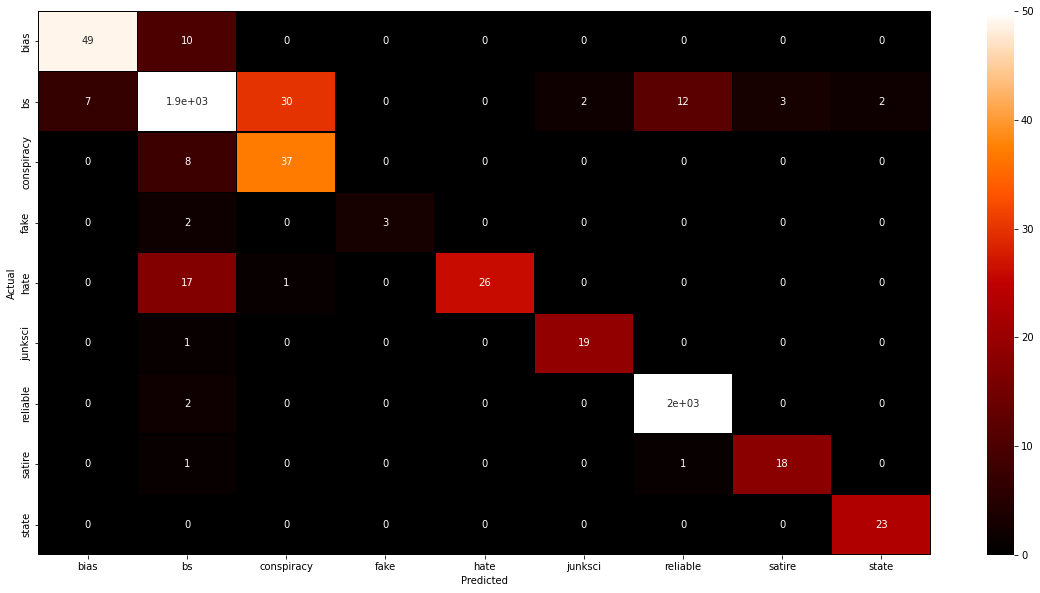

In [ ]:
labels = ['bias', 'bs', 'conspiracy', 'fake', 'hate', 'junksci', 'reliable', 'satire', 'state']
cm = confusion_matrix(targets2, dec2, labels = labels)
plt.figure(figsize=(20,10))
heatmap = sns.heatmap(cm, cmap='gist_heat', annot=True, xticklabels=labels, yticklabels=labels, vmax=50, vmin=0, linewidths=.3, linecolor='black')
heatmap.set(xlabel="Predicted", ylabel = "Actual")

In [ ]:
accuracy_score(targets2, dec2)

0.9761503252228378

In [ ]:
print(classification_report(targets2, dec2))

              precision    recall  f1-score   support

        bias       0.88      0.83      0.85        59
          bs       0.98      0.97      0.97      1941
  conspiracy       0.54      0.82      0.65        45
        fake       1.00      0.60      0.75         5
        hate       1.00      0.59      0.74        44
     junksci       0.90      0.95      0.93        20
    reliable       0.99      1.00      1.00      1994
      satire       0.86      0.90      0.88        20
       state       0.92      1.00      0.96        23

    accuracy                           0.98      4151
   macro avg       0.90      0.85      0.86      4151
weighted avg       0.98      0.98      0.98      4151

